In [27]:
import sys
from xgboost import XGBClassifier, cv
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost
from joblib import dump, load
from datetime import datetime, date
import matplotlib.pyplot as plt
plt.style.use('dark_background')



In [ ]:
train_df = gpd.read_file('train.geojson', index_col=0)
test_df = gpd.read_file('test.geojson', index_col=0)

In [36]:
#Utils
def moy(L):
    if len(L) == 0:
        return 0
    return sum(L)/len(L)

def most_freq(lst):
    if len(lst) == 0:
        return 13
    return max(set(lst), key=lst.count)

In [38]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}

#Step are strings. Steps in the same tuple are considered similar enough. The order of steps_tuple defines the order of steps in reality.
steps_tuple = [('Greenland', 'Land Cleared'), 
             ('Prior Construction',), 
             ('Materials Dumped',),
             ('Construction Started', 'Excavation'),
             ('Construction Midway',),
             ('Construction Done','Operational'),
             ]
format_date = "%d-%m-%Y"
N_a = len(steps_tuple)-1
steps = ()
for step_tuple in steps_tuple:
    steps += step_tuple


#Step (string) to avancement (int)
def step2av(step):
    '''
    Input: step is a string
    Output: av is an int representing avancement
    '''
    for i, steps in enumerate(steps_tuple):
        if step in steps:
            return i
    if step != 'NA': print(step)
    return 'NA'

    
def extract_features_date(df, ratio = 3600 * 24 ):
    global n_na_found, n_na_only_found
    n_na_found = 0
    n_na_only_found = 0
    verbose = False    
    
    int_adv_to_D = [list() for _ in range(N_a)]
    int_adv_to_M = [list() for _ in range(N_a)]
    
    #Extract durations between two dates
    date1 = df['date1'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    date2 = df['date2'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    date3 = df['date3'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    date4 = df['date4'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    date5 = df['date5'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df['diff1'] = (date2 - date1).apply(lambda x: x.total_seconds() / ratio)
    df['diff2'] = (date3 - date2).apply(lambda x: x.total_seconds() / ratio)
    df['diff3'] = (date4 - date3).apply(lambda x: x.total_seconds() / ratio)
    df['diff4'] = (date5 - date4).apply(lambda x: x.total_seconds() / ratio)

    
        
    #Extract duration and month where each advancement was made.
    def augment_date(row):
        
        #Feature for describing if construction is done at date5
        is_constructed = int(row['change_status_date5'] == 'Construction Done')
        
        #List [duration_for_reaching_avancement_A for A in Avancements]
        duration_for_reaching = ['ToCompute' for _ in range(N_a)]
        #List [int_representing_month_where_advancementA_was_made for A in Avancements]
        month_where_was = ['ToCompute' for _ in range(N_a)]
        #[0,0,1,3,5]
        L_int_steps = [step2av(row[status]) for status in ('change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4', 'change_status_date5')]    
        
        #If some steps are NA return list of unknown
        if 'NA' in L_int_steps:
            return [is_constructed] + ["Unknown" for _ in range(N_a)]  #  + ["Unknown" for _ in range(N_a)]   #MONTHS
                   
        #Each time we do an advancement (ie step changes), we fill the list duration_for_reaching with the diff time. 
        #If severals advancements are made we divise the duration by the number of advancements.
        #To implement: instead of divising by the duration, for each advancement A, we do duration(A) = D(A) / Sum_A(D(A)) where D(A) is the mean duration of the advancement, computed on data where advancement was reached in one step
        for k in range(len(L_int_steps)-1):
            int_step = L_int_steps[k]
            int_step_next = L_int_steps[k+1]
            if verbose: print("STEP", k, int_step, int_step_next)            
            
            if int_step_next > int_step:
                if verbose: print(f"step {int_step} to step {int_step_next} happened at time {k}")
                for u in range(int_step, int_step_next):
                    #If severals advancement are made between only two dates, the duration of each advancement is the duration divided by the number of dates-1.
                    duration_for_reaching[u] = (row['diff' + str(k+1)] / (int_step_next-int_step))
                    
                    #The month where EVERY (Implement: not every advancements happend at the same time...) advancements are made is the month of the date between two dates
                    t1 = datetime.timestamp(datetime.strptime(row["date" + str(k+1)], format_date))
                    t2 = datetime.timestamp(datetime.strptime(row["date" + str(k+2)], format_date))
                    month_where_was[u] = datetime.fromtimestamp(t1 + (t2-t1)/2).month
                if int_step_next - int_step == 1:
                    #Save the duration and the mean in list
                    int_adv_to_D[int_step].append(duration_for_reaching[u])
                    int_adv_to_M[int_step].append(month_where_was[u])
                
        if 'ToCompute' in duration_for_reaching:
            # print(duration_for_reaching)
            pass

        L = [is_constructed, ] + duration_for_reaching 
        #L += month_where_was                               #MONTHS
        # sys.exit()
        return L
    
    
    #Nom des features
    columns_names = ['is_constructed'] + ['duration_to_reach' + str(step2av(step[0])) for step in steps_tuple[1:]] 
    #columns_names += ['month_of_advancement' + str(step2av(step[0])) for step in steps_tuple[1:]]                      #MONTHS 
    
    #Features augmentées 
    df_augment = df.apply(lambda row: pd.Series(augment_date(row), index=columns_names), axis=1)
    
    #Fill 
    #Features avec des NA remplacés par durées moyennes
    int_adv_to_D = [moy(L) for L in int_adv_to_D]
    int_adv_to_M = [most_freq(L) for L in int_adv_to_M]
    def fill_NA(row):
        global n_na_found
        max_size = 10000
        R = row.copy()
        
        #The last ToCompute values (meaning it was not computed ie advancement hasnt been reached) are given the values None
        for col in ['duration_to_reach' + str(step2av(step[0])) for step in steps_tuple[1:]][::-1]:
            if row[col] == "ToCompute":
                R[col] = max_size
            else:
                break
        #The first ToCompute values (meaning for advancement i->i+1, step i hasnt been seen because photos were made after this step) are given the mean values
        for i, col in enumerate(['duration_to_reach' + str(step2av(step[0])) for step in steps_tuple[1:]]):
            if row[col] in ("ToCompute", "Unknown"):
                R[col] = int_adv_to_D[i]
                
        return R
    df_augment = df_augment.apply(lambda row: pd.Series(fill_NA(row), index=columns_names), axis = 1)
    
    #Add durations
    df_augment[['diff1', 'diff2', 'diff3', 'diff4']] = df[['diff1', 'diff2', 'diff3', 'diff4']]
    #Add dates
    df_augment['old1'] = (datetime.now() - date1).apply(lambda x: x.total_seconds() / ratio)
    df_augment['old2'] = (datetime.now() - date2).apply(lambda x: x.total_seconds() / ratio)
    df_augment['old3'] = (datetime.now() - date3).apply(lambda x: x.total_seconds() / ratio)
    df_augment['old4'] = (datetime.now() - date4).apply(lambda x: x.total_seconds() / ratio)
    df_augment['old5'] = (datetime.now() - date5).apply(lambda x: x.total_seconds() / ratio)
    
    print(f"NA :{n_na_found}")
    return df_augment

N_max = 999999999
df_aug = extract_features_date(train_df)
df_aug.head()
df_aug.to_csv('train_df_dates.csv')




NA :0


In [ ]:
df_aug = extract_features_date(test_df)
df_aug.head()
df_aug.to_csv('train_df_dates.csv')

duration_to_reach1


c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\t

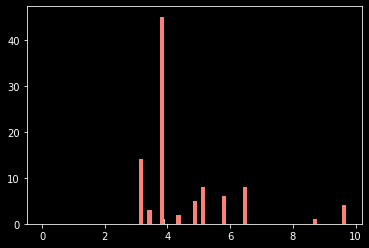

duration_to_reach2


c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\t

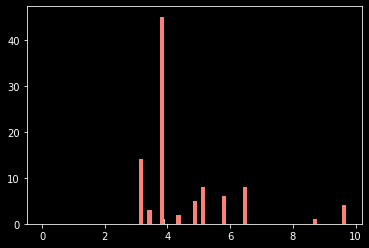

duration_to_reach3


c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\t

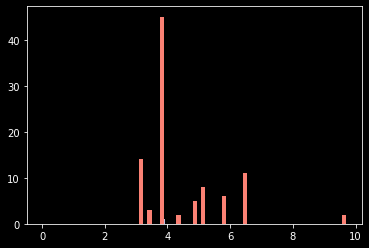

duration_to_reach4


c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\t

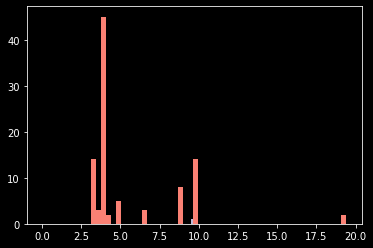

duration_to_reach5


c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\timot\compet_ml\venvCOMPET\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\t

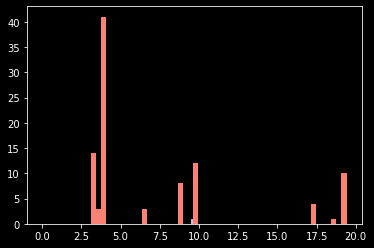

In [6]:

for col in ['duration_to_reach' + str(step2av(step[0])) for step in steps_tuple[1:]]:
    print(col)
    for y in change_type_map:
        df_float = df_aug[(df_aug[col].map(type) == float) & (train_df["change_type"] == y)]
        plt.hist(df_float[col], bins = 50)
    plt.show()

In [ ]:
train_df.head()

,index,change_type,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,date1,date2,date3,date4,date5,urban_types,geography_types,geometry,diff1,diff2,diff3,diff4
0,0,Commercial,Land Cleared,Construction Midway,Construction Done,Construction Done,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Industrial,"River,Sparse Forest,Grass Land","POLYGON ((116.97563 38.89002, 116.97590 38.890...",40780800.0,45878400.0,51148800.0,50716800.0
1,1,Commercial,Greenland,Greenland,Construction Done,Construction Done,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Sparse Urban,"Sparse Forest,Grass Land","POLYGON ((116.97500 38.88969, 116.97524 38.889...",40780800.0,45878400.0,51148800.0,50716800.0
2,2,Commercial,Land Cleared,Land Cleared,Construction Done,Construction Done,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Sparse Urban,"Sparse Forest,Grass Land","POLYGON ((116.97519 38.88847, 116.97568 38.888...",40780800.0,45878400.0,51148800.0,50716800.0
3,3,Commercial,Land Cleared,Land Cleared,Construction Midway,Construction Midway,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Industrial,"River,Sparse Forest,Grass Land","POLYGON ((116.97630 38.89017, 116.97730 38.890...",40780800.0,45878400.0,51148800.0,50716800.0
4,4,Commercial,Land Cleared,Land Cleared,Construction Started,Construction Midway,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Industrial,"River,Sparse Forest,Grass Land","POLYGON ((116.97751 38.89037, 116.97854 38.890...",40780800.0,45878400.0,51148800.0,50716800.0
